# Description

This notebooks performs QA checks for a single vendor:
   - Number of NaN data points as % of total
   - Number of data points where `volume=0` as % of total

# Imports

In [1]:
import logging
import os

import core.config.config_ as cconconf
import core.config.config_utils as ccocouti
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hprint as hprint
import helpers.hs3 as hs3
import im_v2.ccxt.data.client as icdcl
import research_amp.cc.qa as ramccqa

/app/helpers/hparquet.py:19: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-f8514374-fb82-45f4-88bf-326a72075423.json'
INFO  # Git
    branch_name='CMTask2360_Run_C1b_for_top30_CCXT'
    hash='21f7c4184'
    # Last commits:
      * 21f7c4184 max-rsrch Update the universe                                               (22 minutes ago) Thu Jul 14 13:39:55 2022  (HEAD -> CMTask2360_Run_C1b_for_top30_CCXT)
      * f32af0a61 Grigorii Pomazkin Cm task2362: fix fail (#2363)                                     (  14 hours ago) Thu Jul 14 00:11:34 2022  (origin/master, origin/HEAD, origin/CMTask2319_spot_download_fail, master)
      * b641d730e Nina Lee CMTask2305: Add tests for C1b and Example1 (#2350)                (  21 hours ago) Wed Jul 13 16:59:50 2022           
# Machine info
    system=Linux
    node name=7ba59cf2de25
    release=5.15.0-1015-aws
    version=#19~20.04.1-Ubuntu SMP Wed Jun 22 19:07:51 UTC 2022
    machine=x86_64
    processor=x86_64


# Configs

In [3]:
def get_cmtask2360_config() -> cconconf.Config:
    """
    Get task2360-specific config.
    """
    config = cconconf.Config()
    param_dict = {
        "data": {
            # Parameters for client initialization.
            "im_client": {
                "universe_version": "v7",
                "resample_1min": False,
                "root_dir": os.path.join(
                    hs3.get_s3_bucket_path("ck"), "reorg", "historical.manual.pq"
                ),
                "partition_mode": "by_year_month",
                "dataset": "ohlcv",
                "contract_type": "futures",
                "data_snapshot": "20220707",
                "aws_profile": "ck",
            },
            # Parameters for data query.
            "read_data": {
                "start_ts": None,
                "end_ts": None,
                "columns": ["full_symbol", "close", "volume"],
                "filter_data_mode": "assert",
            },
        },
        "column_names": {
            "full_symbol": "full_symbol",
            "close_price": "close",
        },
        "stats": {
            "threshold": 30,
        },
    }
    config = cconfig.Config.from_dict(param_dict)
    return config


config = get_cmtask2360_config()
print(config)

data:
  im_client:
    universe_version: v7
    resample_1min: False
    root_dir: s3://cryptokaizen-data/reorg/historical.manual.pq
    partition_mode: by_year_month
    dataset: ohlcv
    contract_type: futures
    data_snapshot: 20220707
    aws_profile: ck
  read_data:
    start_ts: None
    end_ts: None
    columns: ['full_symbol', 'close', 'volume']
    filter_data_mode: assert
column_names:
  full_symbol: full_symbol
  close_price: close
stats:
  threshold: 30


# Load the data

In [4]:
client = icdcl.CcxtHistoricalPqByTileClient(**config["data"]["im_client"])

In [5]:
universe = client.get_universe()
universe

['binance::ADA_USDT',
 'binance::APE_USDT',
 'binance::AVAX_USDT',
 'binance::AXS_USDT',
 'binance::BAKE_USDT',
 'binance::BNB_USDT',
 'binance::BTC_BUSD',
 'binance::BTC_USDT',
 'binance::CRV_USDT',
 'binance::CTK_USDT',
 'binance::DOGE_USDT',
 'binance::DOT_USDT',
 'binance::DYDX_USDT',
 'binance::ETH_BUSD',
 'binance::ETH_USDT',
 'binance::FTM_USDT',
 'binance::GMT_USDT',
 'binance::LINK_USDT',
 'binance::MATIC_USDT',
 'binance::NEAR_USDT',
 'binance::OGN_USDT',
 'binance::RUNE_USDT',
 'binance::SAND_USDT',
 'binance::SOL_USDT',
 'binance::STORJ_USDT',
 'binance::UNFI_USDT',
 'binance::WAVES_USDT',
 'binance::XRP_USDT']

In [6]:
data = client.read_data(universe, **config["data"]["read_data"])
data.head(3)

,full_symbol,close,volume
timestamp,,,
2019-09-08 17:57:00+00:00,binance::BTC_USDT,10000.0,0.001
2019-09-08 17:58:00+00:00,binance::BTC_USDT,10000.0,0.000
2019-09-08 17:59:00+00:00,binance::BTC_USDT,10000.0,0.001


# QA checks

Major metric for a QA check is `"bad data [%]"` which is the sum of `"volume=0 [%]"` and `"NaNs [%]"`.

In [7]:
vendor_name = "CCXT"
binance_timestamp_stats = ramccqa.get_timestamp_stats(data, vendor_name)
binance_timestamp_stats

,min_timestamp,max_timestamp,days_available
binance::ADA_USDT,2020-01-31 08:01:00+00:00,2022-07-07 07:59:00+00:00,887
binance::APE_USDT,2022-03-17 15:00:00+00:00,2022-07-07 07:59:00+00:00,111
binance::AVAX_USDT,2020-09-23 07:00:00+00:00,2022-07-07 07:59:00+00:00,652
binance::AXS_USDT,2020-11-20 07:04:00+00:00,2022-07-07 07:59:00+00:00,594
binance::BAKE_USDT,2021-05-19 07:00:00+00:00,2022-07-07 07:59:00+00:00,414
binance::BNB_USDT,2020-02-10 08:01:00+00:00,2022-07-07 07:59:00+00:00,877
binance::BTC_BUSD,2021-01-12 07:00:00+00:00,2022-07-07 07:59:00+00:00,541
binance::BTC_USDT,2019-09-08 17:57:00+00:00,2022-07-07 07:59:00+00:00,1032
binance::CRV_USDT,2020-09-01 07:01:00+00:00,2022-07-07 07:59:00+00:00,674
binance::CTK_USDT,2020-11-19 07:00:00+00:00,2022-07-07 07:59:00+00:00,595


In [8]:
agg_level_full_symbol = ["full_symbol"]
binance_bad_data_stats = ramccqa.get_bad_data_stats(
    data, agg_level_full_symbol, vendor_name
)
binance_bad_data_stats

,bad data [%],missing bars [%],volume=0 [%],NaNs [%]
binance::ADA_USDT,0.525213,0.000000,0.525213,0.0
binance::APE_USDT,0.039786,0.000000,0.039786,0.0
binance::AVAX_USDT,0.043773,0.000000,0.043773,0.0
binance::AXS_USDT,0.036590,0.000000,0.036590,0.0
binance::BAKE_USDT,0.015766,0.000000,0.015766,0.0
binance::BNB_USDT,0.062722,0.000000,0.062722,0.0
binance::BTC_BUSD,0.052882,0.000000,0.052882,0.0
binance::BTC_USDT,0.031542,0.000067,0.031474,0.0
binance::CRV_USDT,0.078301,0.000000,0.078301,0.0
binance::CTK_USDT,0.121490,0.000000,0.121490,0.0


In [9]:
agg_level_full_symbol_year_month = ["full_symbol", "year", "month"]
bad_data_stats_by_year_month = ramccqa.get_bad_data_stats(
    data, agg_level_full_symbol_year_month, vendor_name
)
bad_data_stats_by_year_month

bad data [%]  missing bars [%]  volume=0 [%]  NaNs [%]
binance::ADA_USDT 2020 1      0.000000               0.0      0.000000       0.0
                       2      0.476533               0.0      0.476533       0.0
                       3      4.298835               0.0      4.298835       0.0
                       4      6.868056               0.0      6.868056       0.0
                       5      3.306452               0.0      3.306452       0.0
...                                ...               ...           ...       ...
binance::XRP_USDT 2022 3      0.000000               0.0      0.000000       0.0
                       4      0.000000               0.0      0.000000       0.0
                       5      0.143369               0.0      0.143369       0.0
                       6      0.000000               0.0      0.000000       0.0
                       7      0.000000               0.0      0.000000       0.0

[610 rows x 4 columns]

/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


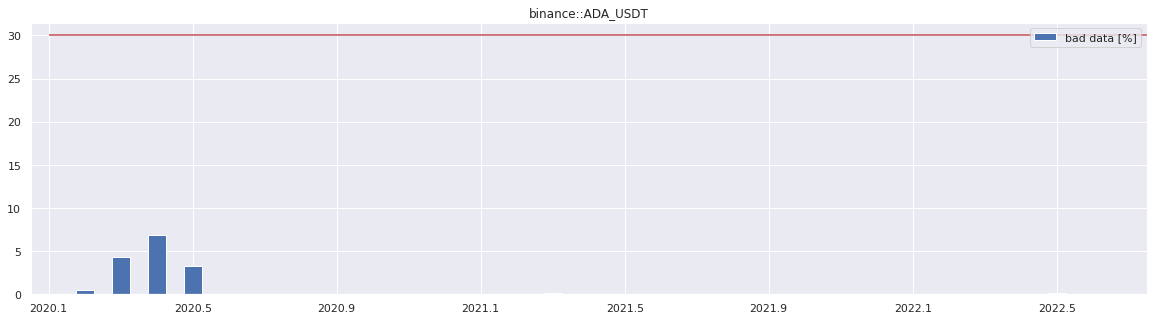

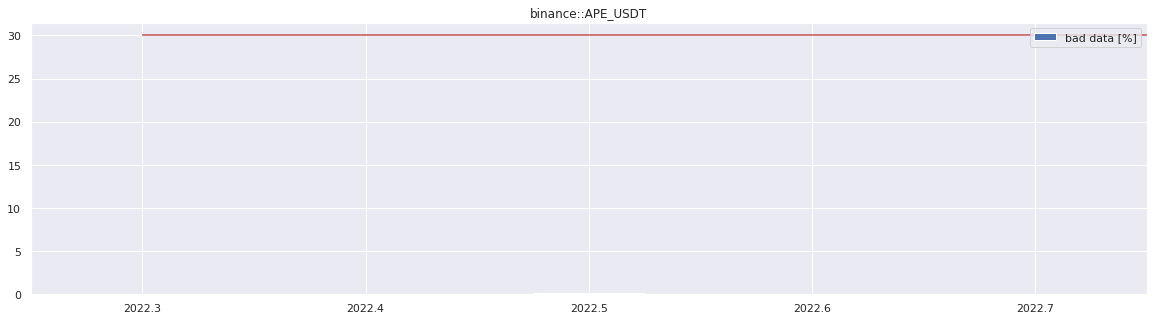

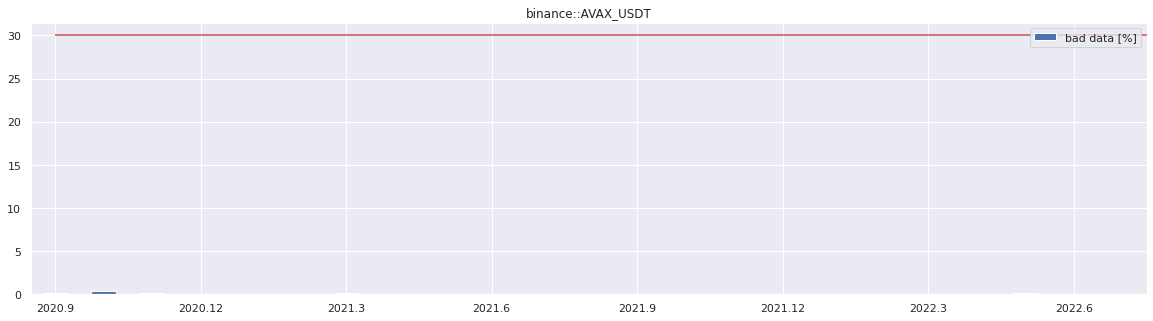

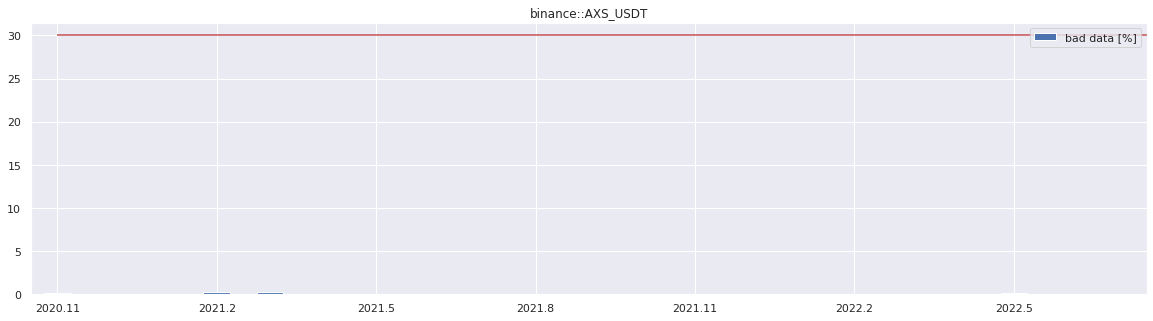

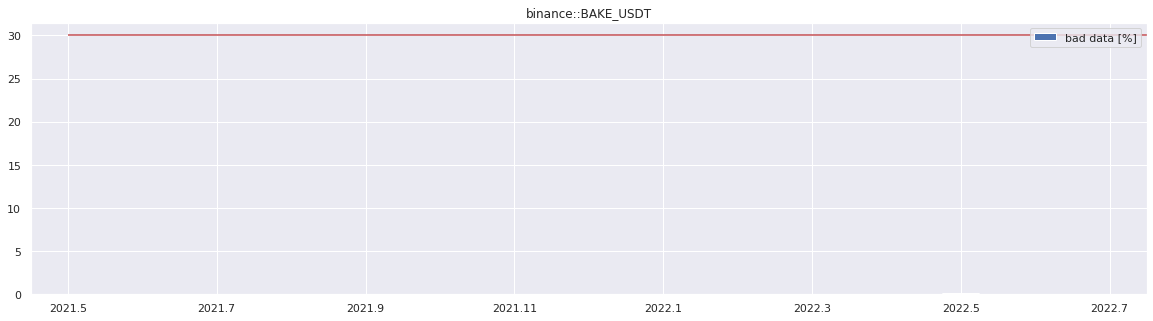

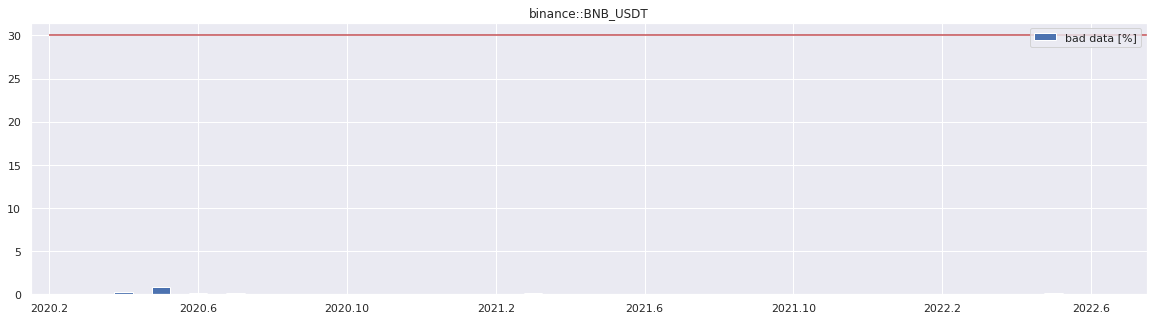

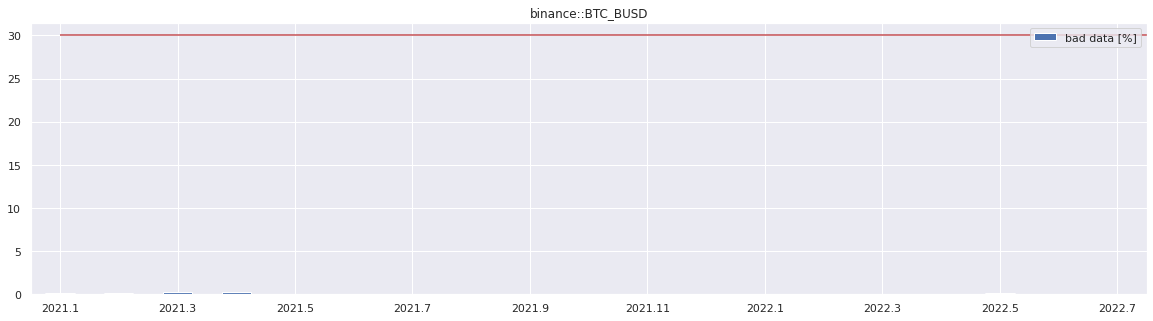

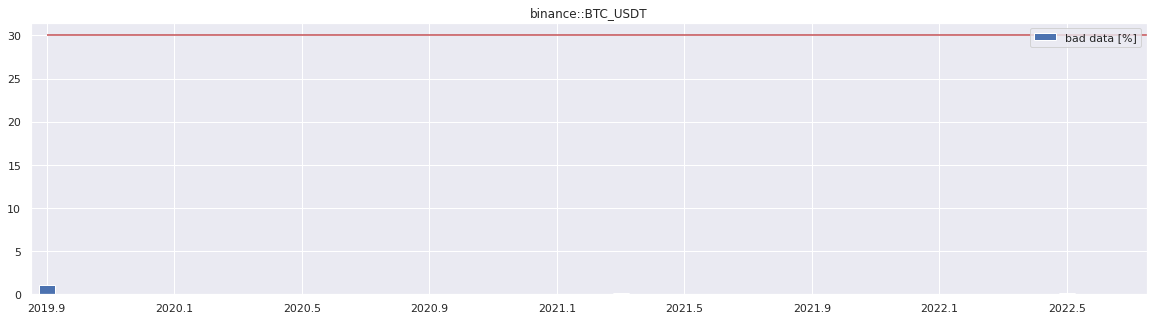

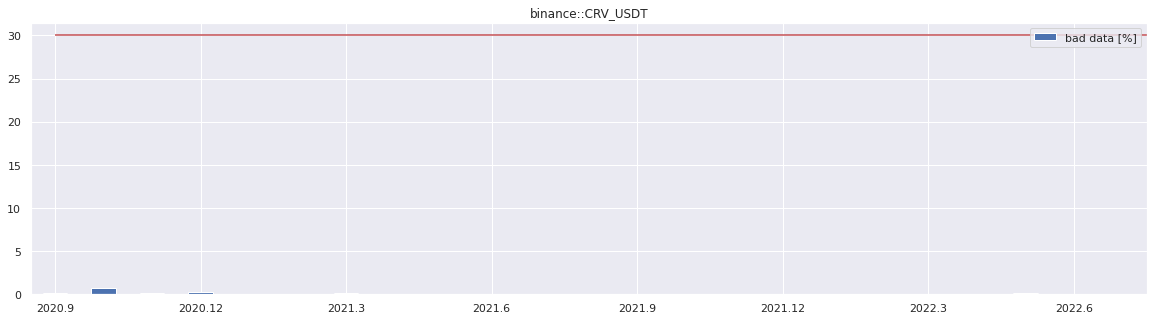

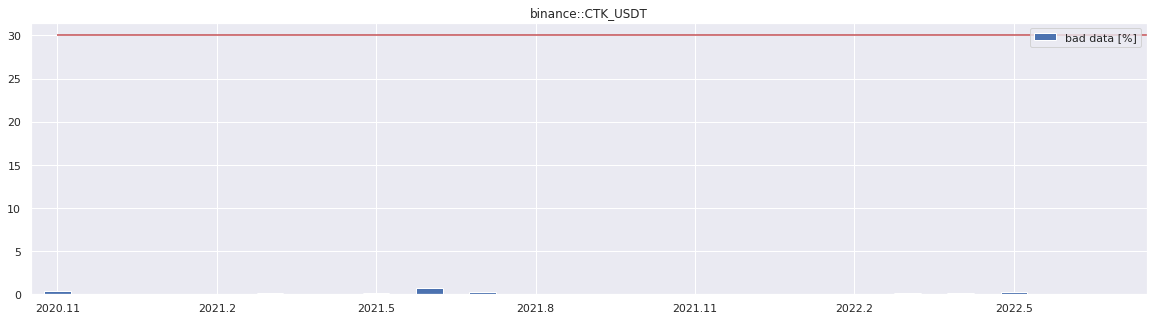

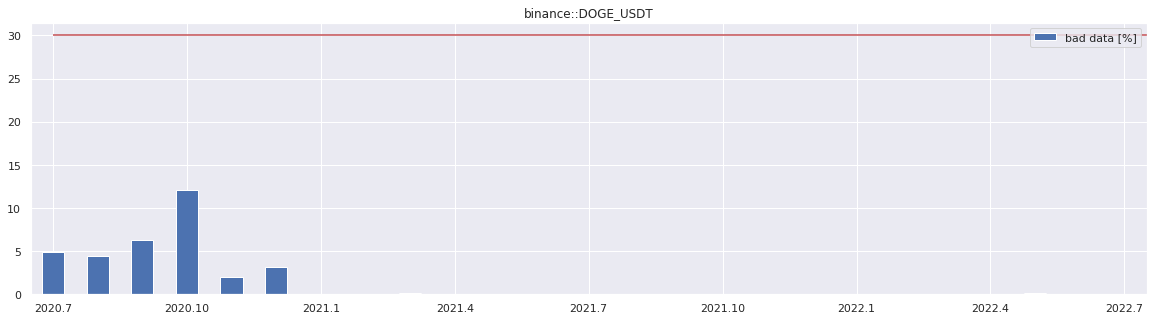

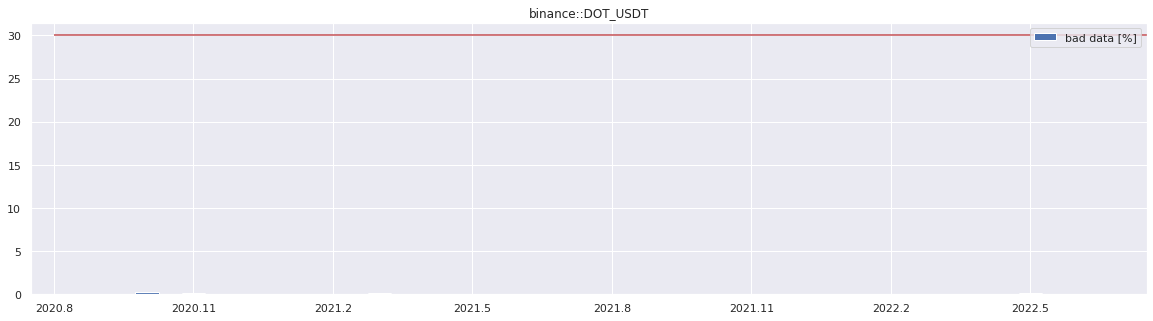

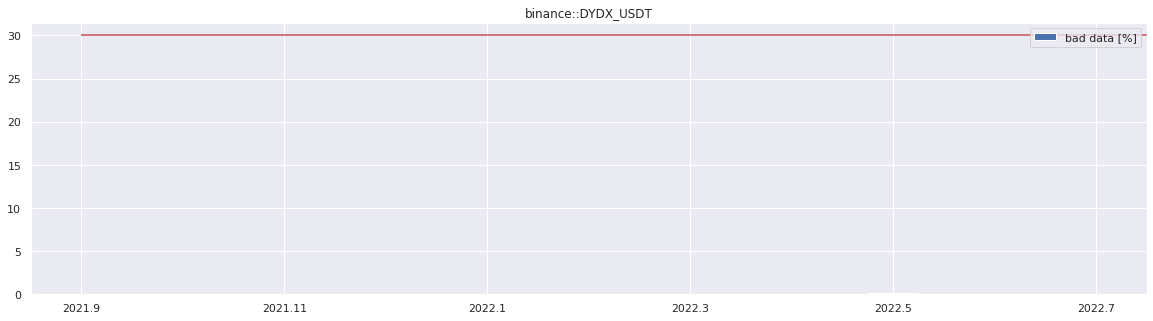

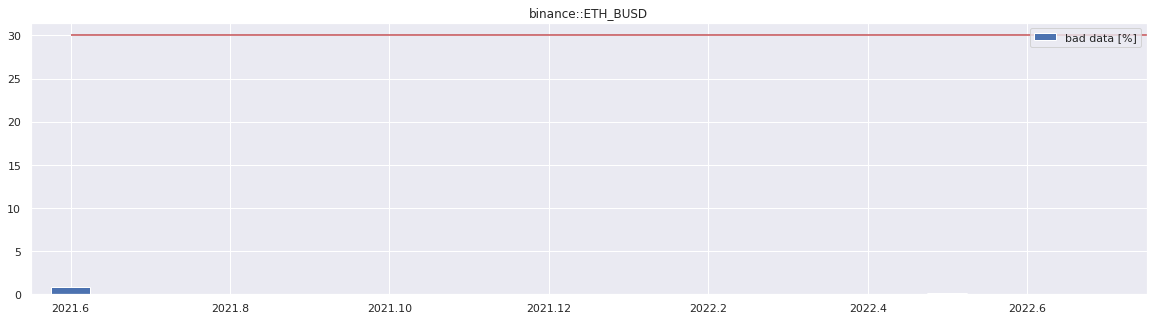

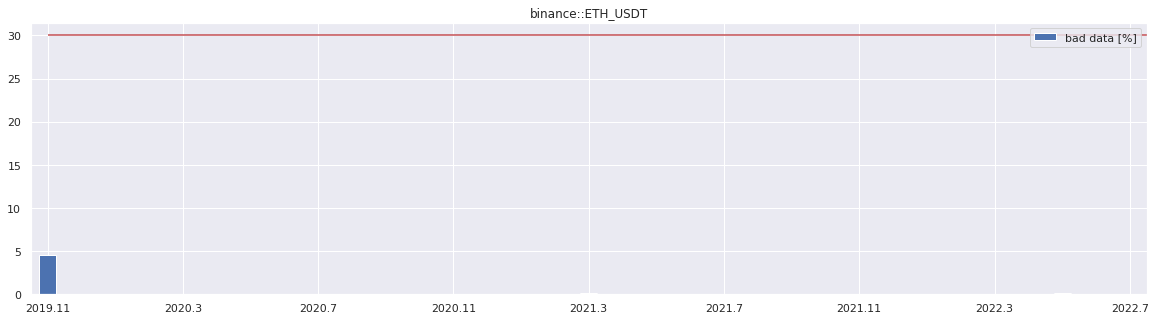

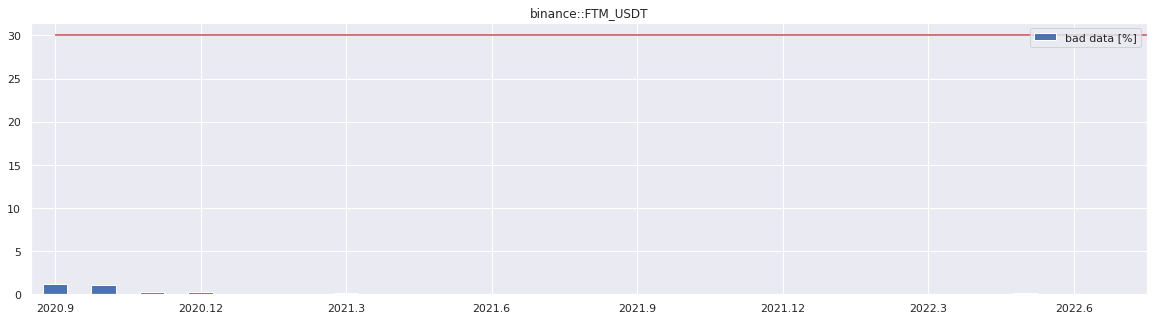

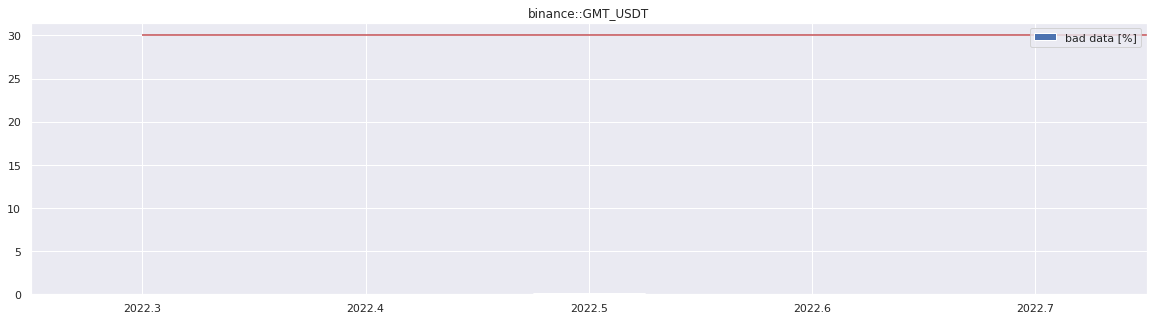

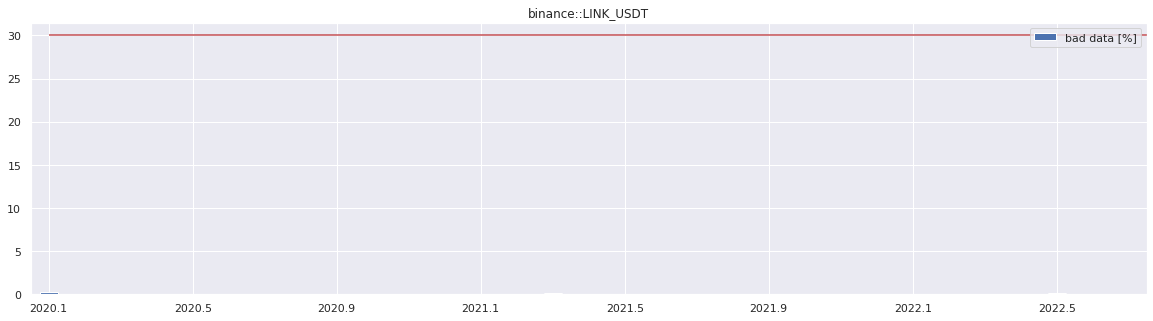

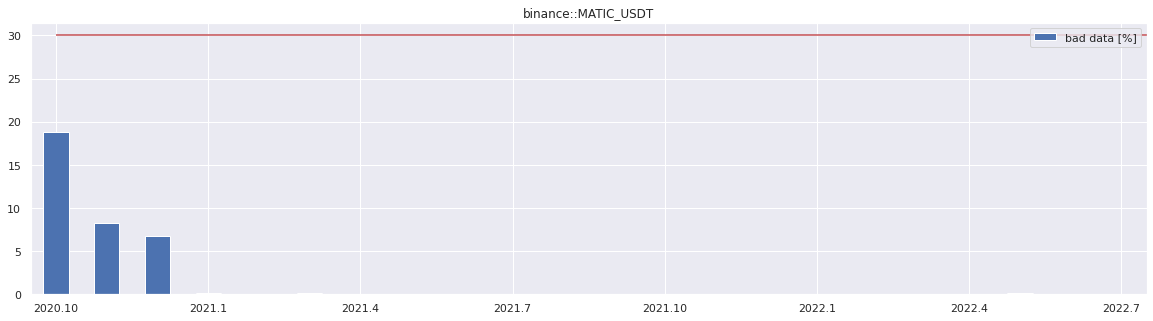

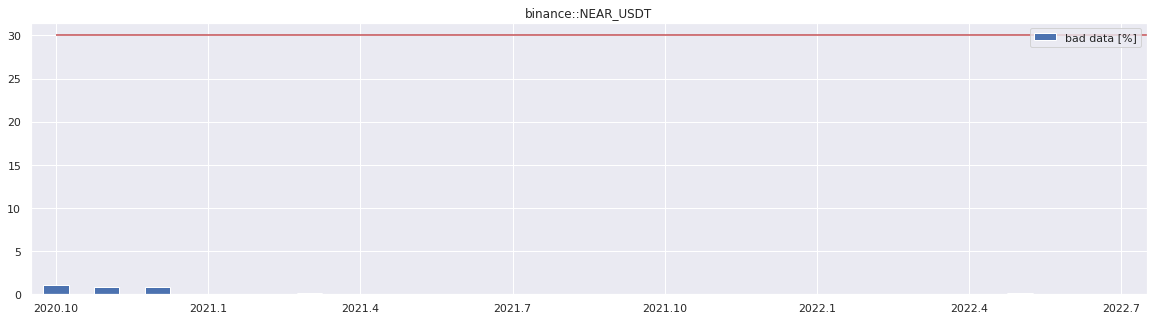

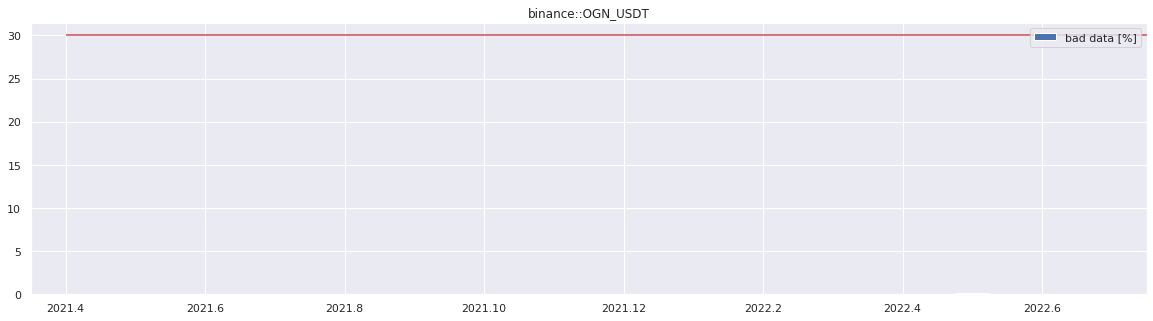

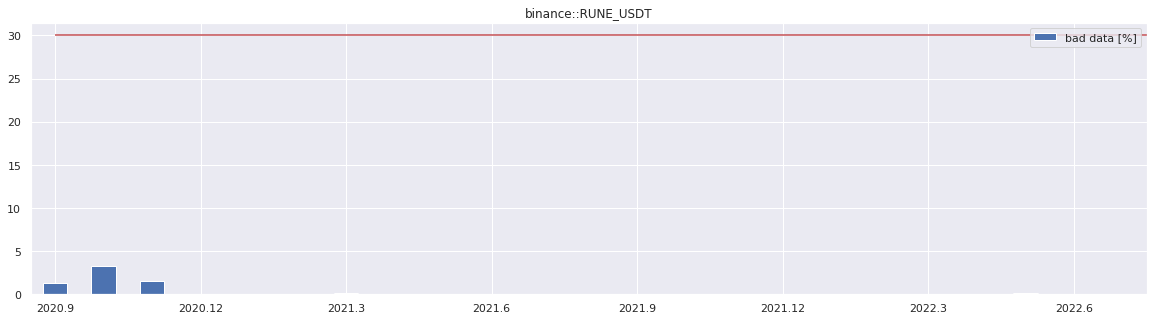

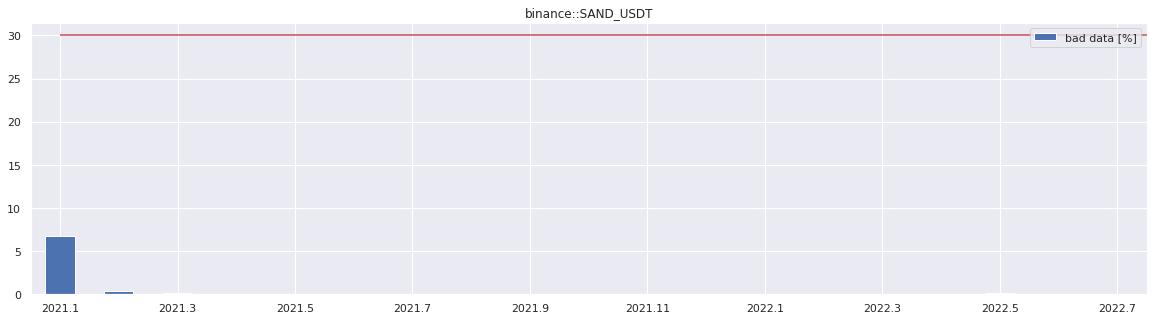

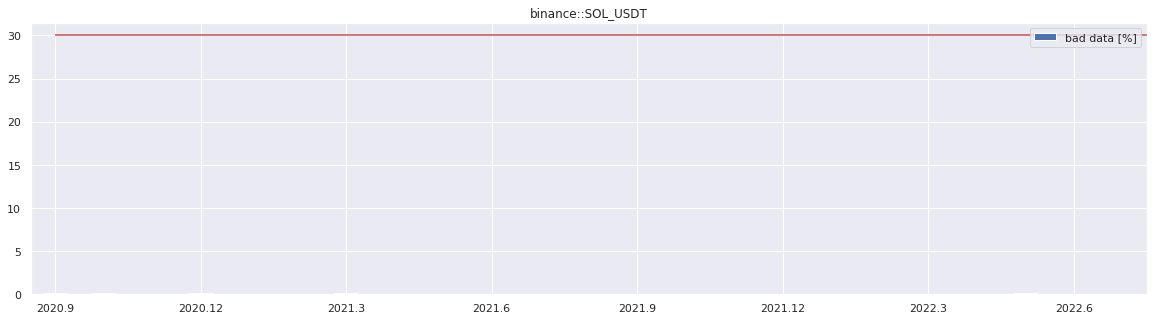

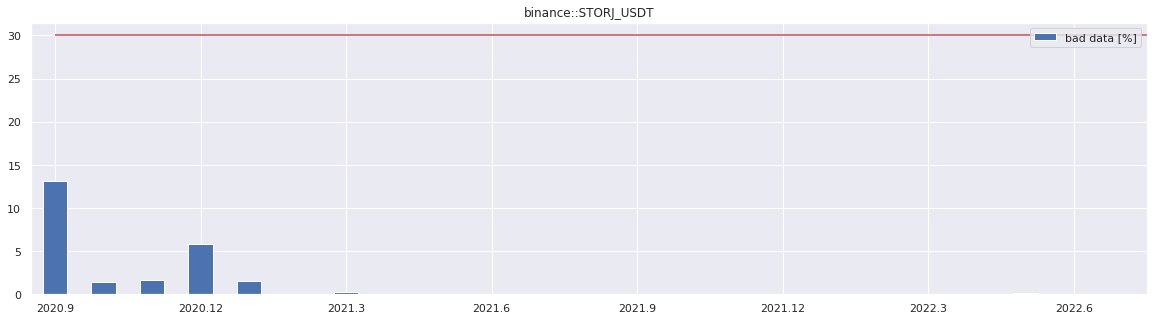

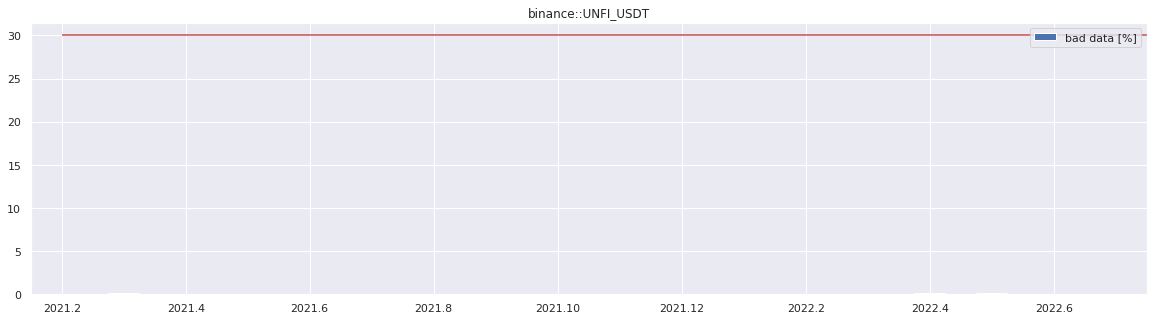

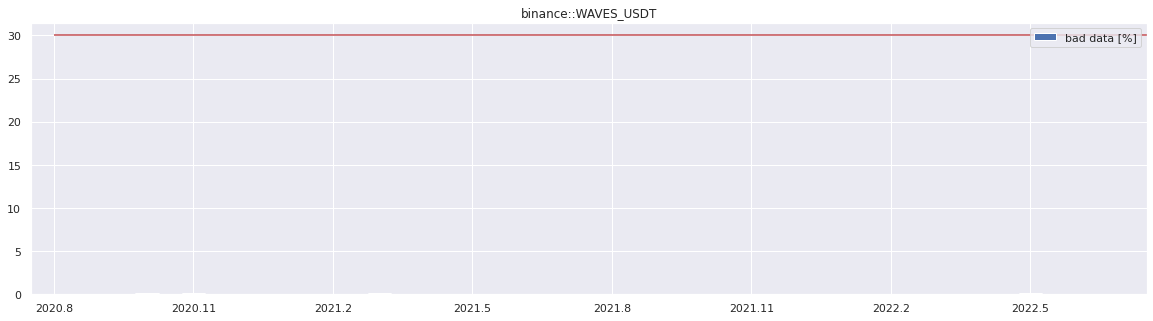

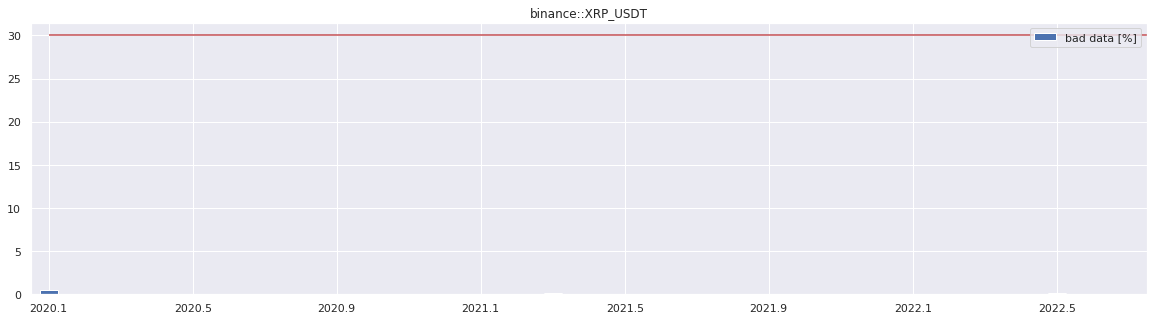

In [10]:
_ = ramccqa.plot_bad_data_by_year_month_stats(
    bad_data_stats_by_year_month, config["stats"]["threshold"]
)